# Integro Differential Equations
Looking at Schaum, Jerono (2019), we can use the provided PDE for modeling the growth population. This results in the following Equation: 
$$
\frac{\partial n(m,t)}{\partial t} = 
- \frac{\partial}{\partial m} \left[ r_g(m, S) \, n(m, t) \right] 
- \Gamma(m, S) \, n(m, t) 
+ 2 \int_m^{m_{\text{max}}} \Gamma(m', S) \, p(m' \to m) \, n(m', t) \, dm' 
- D \, n(m, t)
$$
$$
\dot{S}(t) = - \int_0^{m^+} r_{g}(m, S) \, n(m, t) \, dm
$$
Note that when solving numerically, i do not use the chain rule for the derivative with regards to $m$ (even though i probably should...). Simply because it is easier to implement numerically and i enforce the assumption that the growth rate is independent of the cell mass.The goal is simply to test a NN, so i am not really bothered with the details of the DGL This assumption might not be accurate, however it simplifies the equation.
Therefore we make the approximation : 
$$
\frac{\partial}{\partial m} \left[ r_g \, n \right] 
\approx \frac{(r_g \, n)_i - (r_g \, n)_{i-1}}{\Delta m}
$$ 

Since $n=f(m,t)$ we have to solve this numerically. Therefore we discretize the System over the mass-Domain with regards to $$\Delta m=m_{i}-m_{i-1}$$ and then solve it for small time increments $\Delta t$. Basically creating a System of ODEs for each incremental Distribution $n_{i}$

Now to make this look more "mathematical" i introduce :
$$
\begin{aligned}
& \Delta m = m_i - m_{i-1}  ,  i  \epsilon [1,M] \\
& n_i(t) \approx n(m_i, t) \\
& r_{g,i}(S) = r_g(m_i, S) \\
& \Gamma_i(S) = \Gamma(m_i, S) \\
& p_{k \to i} \approx p(m_k \to m_i)
\end{aligned}
$$
The integral term can be approximated by the sum over the increments,so that for each $n_{i}$ we can apply : 
$$
\frac{d n_i}{dt} = 
- \frac{(r_g \, n)_i - (r_g \, n)_{i-1}}{\Delta m}
- \Gamma_i(S) \, n_i
+ 2 \sum_{k=i}^{M} \Gamma_k(S) \, p_{k \to i} \, n_k \, \Delta m
- D \, n_i
$$
and also the additional condition for the Substrate :
$$
\frac{dS}{dt} = - \sum_{i=0}^{M} r_{g,i}(S) \, n_i \, \Delta m
$$

Now lets get to coding...



# Numeric Simulation

In [109]:
#imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random #for random starting values around a mean value 
import math
from functools import partial
import pickle

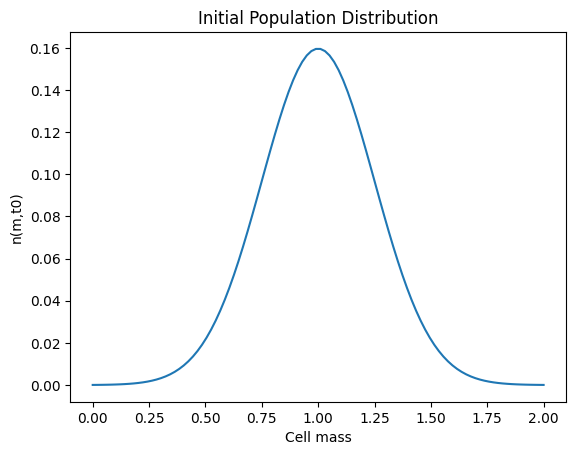

In [110]:
#domain and parameters
M  =  100
m_min,  m_max   =    0.0,    2.0
minimal_division_mass=0.1
m = np.linspace(m_min, m_max, M)
delta_m = m[1] - m[0]

q=5         #for the probability distribution- important--> q>1. for q<1--> divergence, p=1--> P[k:, 0] is not 0 anymore (cells could falsly split into cells of size 0!)
Bqq = math.gamma(q) * math.gamma(q) / math.gamma(2*q)
se=5


#functions for growth rate/death rate...
def r_g (m_i, S):
    ks_max=0.8
    K_s=2
    rho = (ks_max * S)/ (K_s+S)             #Monod Kinetics for the growth rate 
    r_g=rho*m_i 
    return r_g

def Gamma(m_i,S,minimal_division_mass):
    beta = 1.0
    gamma_m = np.where(m_i < minimal_division_mass, 0.0, beta * m_i)
    return gamma_m * r_g(m_i, S)


def build_P(m, q, Bqq,delta_m):
    M = len(m)
    P = np.zeros((M, M))
    for k in range(M):
        mk = m[k]
        if mk <= 0:
            continue
        # base beta density over daughters i < k
        x = m[:k] / mk
        nonzero_vals = (1.0 / Bqq) * (1.0 / mk) * (x ** (q - 1)) * ((1 - x) ** (q - 1))

        P[k, :k] = nonzero_vals

        #  (1) probability normalization: sum_i P[k,i] delta_m = 1
        Z = np.sum(P[k, :k]) * delta_m
        if Z > 0:
            P[k, :k] /= Z

        # (2) first moment: 2 * sum_i m_i P[k,i] Δm = m_k
        mom = np.sum(m[:k] * P[k, :k]) * delta_m
        if mom > 0:
            P[k, :k] *= (0.5 * mk / mom)
    return P

#INPUTS
# Sinoid input
def D_func_1(t,i):
    return np.sin(t/i)/2.5 + 0.4
#step function
def D_func_2(t,i):
    return np.ones_like(t) * i
   
def population_system (t, y, m, q, Bqq, delta_m, se, minimal_division_mass, i,D_func=None):
    n=y[:-1]
    S=y[-1] 
    P=build_P(m,q,Bqq,delta_m)
    dn_dt= np.zeros_like(n)


    r_g_values = r_g(m,S)
    Gamma_values=Gamma(m,S,minimal_division_mass)
    
    # Compute the finite difference approximation for ∂/∂m (r_g * n)
    rg_n = r_g_values * n
    rg_n[-1]=0                  #important! cells at maximum cell size cannot grow any further, thus do not take up any substrate!
    
    d_rg_n_dm = np.zeros_like(n)
    d_rg_n_dm[1:] = (rg_n[1:] - rg_n[:-1]) / (delta_m)

    # boundary treatment 
    d_rg_n_dm[0] = rg_n[0] /delta_m # is this correct?   
    
    
    #input
    if D_func is not None: 
        D_t = D_func(t, i)  # <-- get dilution rate at time t
    else : D_t=0
    #loss and gain terms 
    dilution_loss = D_t * n          
    division_loss = Gamma_values * n
    division_gain= 2.0 * delta_m * (Gamma_values * n) @ P
   
 
    flux_out = rg_n[-1]     #the theoretical flux that comes from the largest cells growing (BUT since they cant grow by construction, this term is incorporated to the dn_dt[-1])
    dn_dt = -d_rg_n_dm - division_loss + division_gain -dilution_loss
    dn_dt[-1] += flux_out / delta_m
   
    # Substrate equation
    dS_dt =  -np.sum(rg_n) *delta_m +D_t*(se-S)
    

    return np.concatenate([dn_dt, [dS_dt]])


# Initial population n_i



def shifted_gaussian(m, mu, sigma):
    """
    Gaussian-like curve on [0, m_max] with value 0 at m=0.
    
    Parameters:
        m      : scalar or array, domain values
        mu     : mean of the Gaussian
        sigma  : standard deviation of the Gaussian
    
    Returns:
        Gaussian-like values with f(0) = 0 AND a biomass of 1!
    """
    # Standard Gaussian
    g = np.exp(-0.5 * ((m - mu) / sigma) ** 2)
    
    # Subtract the value at m=0
    g0 = np.exp(-0.5 * ((0 - mu) / sigma) ** 2)
    g_shifted = g - g0
    
    # Clip to non-negative (avoid small numerical negatives)
    g_shifted = np.maximum(g_shifted, 0)
    
    # Normalize so the first momentum of the distribution with respect to the mass is 1 -->total biomass 
    
    total = np.sum(m * g_shifted)*delta_m
    g_shifted /= total
    
    return g_shifted
# Example usage


mu=1
sigma=0.25

n0 = shifted_gaussian(m,mu,sigma)   *  0.1            #-->biomass at start =5
plt.plot(m,n0)
plt.title('Initial Population Distribution')
plt.xlabel('Cell mass')
plt.ylabel('n(m,t0)')
plt.show()

                 # Normalize
      
# Initial substrate S
S0 = 5 #g/L

# Combine into single initial condition vector
y0 = np.concatenate([n0, [S0]])
t_span = (0.0, 40.0)
timesteps=400
t_eval = np.linspace(*t_span, timesteps)

# print(sum(n0*m*delta_m))
PDE= partial(
    population_system,
    m=m,
    q=q,
    Bqq=Bqq,
    delta_m=delta_m,
    se=se,
    minimal_division_mass=minimal_division_mass,
    D_func=None,
    i=3
)

sol = solve_ivp(PDE, t_span, y0, t_eval=t_eval, method='RK45')


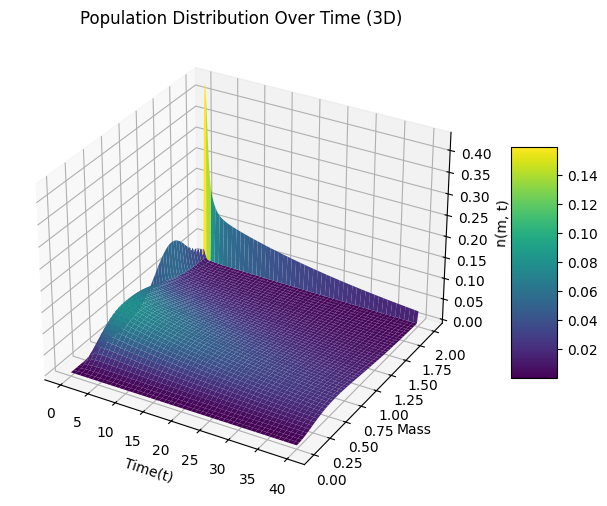

(100, 400)


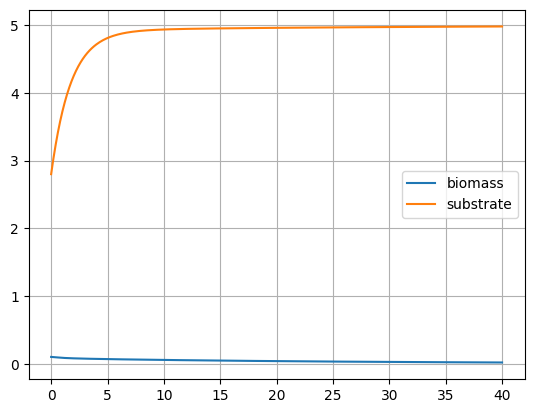

In [128]:
from mpl_toolkits.mplot3d import Axes3D

j=timesteps
# Create a meshgrid for mass (m) and time (t)
T, M_  = np.meshgrid(sol.t[:j], m)  #200x100

# Extract corresponding n(m, t) values for the first j time points
N = sol.y[:-1, :]  # m,t

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(T,M_ , N, cmap='viridis')

ax.set_xlabel('Time(t)')
ax.set_ylabel('Mass')
ax.set_zlabel('n(m, t)')
ax.set_title('Population Distribution Over Time (3D)')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

import plotly.graph_objects as go
import numpy as np


# pick a stride so you don’t draw too many lines
time_idxs = np.arange(0, N.shape[1], 2)

cmin, cmax = N.min(), N.max()
print(N.shape)
traces = []
for i, k in enumerate(time_idxs):
    traces.append(
        go.Scatter3d(
            x=M_[:, k],
            y=T[:, k],
            z=N[:, k],
            mode='lines',
            showlegend=False,           # still no legend for each line
            line=dict(
                color=N[:, k],          # color each point by its density
                colorscale='Viridis',
                cmin=cmin,
                cmax=cmax,
                width=4,
                showscale=(i == 0),       # only the first trace shows the colorbar, so i dont have 200 colorbars
                colorbar=dict(title='n(m, t)') if i == 0 else None
            )
        )
    )

fig = go.Figure(traces)
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='Mass (m)',
            autorange='reversed'    # flip so axis 0 and time axis 0 sort of fit better visually 
        ),
        yaxis=dict(title='Time (t)'),
        zaxis=dict(title='n(m, t)')
    ),
    width=700,
    height=700,
)
fig.show()

biomass=[]
for i in range(len(t_eval)):
    biomass.append(sum(N[:,i]*m*delta_m))

plt.figure()
plt.plot(t_eval,biomass,label='biomass')
plt.plot(t_eval,sol.y[-1, :],label='substrate')
plt.legend(loc='best')
plt.grid()
plt.show()



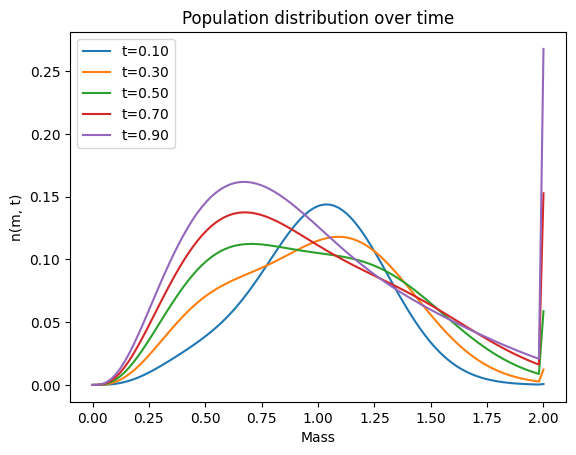

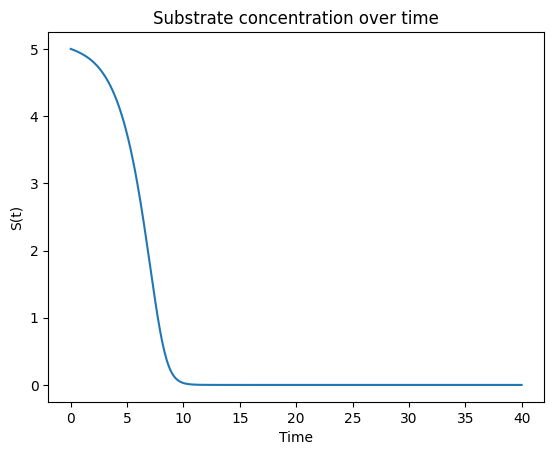

In [112]:


# Plot population distribution at different time steps
for idx in range(1,10,2):
    plt.plot(m, sol.y[:-1, idx], label=f't={sol.t[idx]:.2f}')
plt.xlabel('Mass')
plt.ylabel('n(m, t)')
plt.title('Population distribution over time')
plt.legend()
plt.show()

# Plot substrate over time
plt.plot(sol.t, sol.y[-1, :])
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('Substrate concentration over time')
plt.show()



With the current (randomly chosen) rate $\Gamma$, larger cells/particles are affected a lot more, which is why the number of large cells decreases rapidly over time.


# Generating Training Data
in easy [Cell_growth_easy_Model_with_input](https://github.com/therealtoby1/Master/blob/main/Cell_growth_easy_Model_with_input.ipynb), we trained a model with varying initial biomass and varying input functions. In this more elaborated model, we will also do this, but we will additionally incorporate different initial distributions (for the same biomass)
The way i will do this is i will take 3 distributions per initial condition ending up with :

        (10_initial_conditions (biomass 0.1, substrate {0.1,3}) * 3 initial distributions) * (2_input_functions* 5_variations_per_function) = 300 Training_sets

In [113]:
N_initial_conditions=10
N_initial_distributions=3
N_input_functions=2
N_variations_per_function=5

Dataset = {}

#distributions
mean = [0.25*m_max,
        0.5*m_max,
        0.75*m_max]

sigma=0.25  

#input functions
Input_functions=[D_func_1,
                 D_func_2]
# unique index for each dataset entry
counter = 0  

for i in range(N_initial_conditions):
    initial_biomass=0.1
    initial_substrate = 0.1  + i * 0.3
    for j in range (N_initial_distributions):
        n0 = shifted_gaussian(m,mean[j],sigma)   *  0.1      
        y0 = np.concatenate([n0, [initial_substrate]])
        for k in range (N_input_functions):
            D_training = Input_functions[k]
            for l in range(N_variations_per_function):
                if k==0:
                    tuning_param=l+1
                else: 
                    tuning_param=l/7
                
                PDE= partial(
                            population_system,
                            m=m,
                            q=q,
                            Bqq=Bqq,
                            delta_m=delta_m,
                            se=se,
                            minimal_division_mass=minimal_division_mass,
                            D_func=D_training,
                            i=tuning_param
                        )
                sol = solve_ivp(PDE, t_span, y0, t_eval=t_eval, method='RK45')
                entry = {
                        "n": sol.y[:-1, :],
                        "S": sol.y[-1, :],
                        "U": D_training(t_eval, tuning_param),
                        "initial_substrate": initial_substrate,
                        "mean": mean[j],
                        "sigma": sigma,
                        "D_func": k,
                        "tuning_param": tuning_param
                    }
                Dataset[counter] = entry
                counter += 1
            


with open("Dataset_training_integro_diff.pkl", "wb") as f:
    pickle.dump(Dataset, f)

                    

    



# Neural Network

In [125]:
'''
now we set up a neural network as a function f(n(m,t)) that serves sort of as a forward shift operator and allows us to get the 
value n(m, t+1). Since the System itself is not directly dependent on time, the training pairs for the model should be 
[n(m,t);n(m,t+1)],[n(m,t+1),n(m,t+2)]... 
the subsequent use of the function could then be used to compute the system state after an arbitrarily chosen time t, e.g
n(m,t+2)~   f(n(m,t+1))~    f(f(n(m,t)))
firstly we prepare the data:one part of the data will be used to train, the rest half for validation
to access the solution that was calculated with the original pDE at time t we use sol.y[:-1, t] for n(m,t) and sol.y[-1,t] for S(t) with t being the timestep we evaluated the pde at
'''
import numpy as np
import torch as torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# infer M, T from first entry
first = next(iter(Dataset.values()))
M, T = first["n"].shape

# stack all at once
X_all, Y_all = [], []
for entry in Dataset.values():
    n = entry["n"]      # (M, T)
    s = entry["S"]      # (T,)
    u = entry["U"]      # (T,)

    # X_t = [n(t), s(t), u(t)]
    X = np.concatenate([n[:, :-1], s[:-1][None, :], u[:-1][None, :]], axis=0).T
    # Y_t = [n(t+1), s(t+1)]
    Y = np.concatenate([n[:, 1:],  s[1:][None, :]], axis=0).T

    X_all.append(X)
    Y_all.append(Y)

# final stacked arrays
X_train_np = np.vstack(X_all)  # shape: (total_samples, M+2)
Y_train_np = np.vstack(Y_all)  # shape: (total_samples, M+1)


# optional normalization
X_mean, X_std = X_train_np.mean(0), X_train_np.std(0) + 1e-8
Y_mean, Y_std = Y_train_np.mean(0), Y_train_np.std(0) + 1e-8
X_train_np = (X_train_np - X_mean) / X_std
Y_train_np = (Y_train_np - Y_mean) / Y_std


# torch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32)

# # DataLoader with shuffling for SGD
# train_ds = TensorDataset(X_train, Y_train)
# train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

dim=M+2

#initializing the neural network class that inherits from nn
class Neuralnetwork (nn.Module):
    def __init__(self,dim):
        super(Neuralnetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, 256),
            nn.ReLU(),              #ReLU so no vanishing Gradient and also because it's pretty established...
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, dim-1)     
        )
    def forward(self, x):
        return self.model(x)

model = Neuralnetwork(dim=dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() #mean squared error loss function --randomly chosen, could also use weighted function


for epoch in range(2000): 
    optimizer.zero_grad()
    output = model(X_train)        #calls the forward function of the Neural Network class
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")





Epoch 0, Loss: 1.018280
Epoch 1, Loss: 0.946561
Epoch 2, Loss: 0.889033
Epoch 3, Loss: 0.828469
Epoch 4, Loss: 0.758053
Epoch 5, Loss: 0.677140
Epoch 6, Loss: 0.586832
Epoch 7, Loss: 0.492426
Epoch 8, Loss: 0.402168
Epoch 9, Loss: 0.327283
Epoch 10, Loss: 0.277140
Epoch 11, Loss: 0.249287
Epoch 12, Loss: 0.228313
Epoch 13, Loss: 0.199324
Epoch 14, Loss: 0.159769
Epoch 15, Loss: 0.117227
Epoch 16, Loss: 0.081278
Epoch 17, Loss: 0.057523
Epoch 18, Loss: 0.046290
Epoch 19, Loss: 0.043896
Epoch 20, Loss: 0.044199
Epoch 21, Loss: 0.042833
Epoch 22, Loss: 0.039234
Epoch 23, Loss: 0.034658
Epoch 24, Loss: 0.030678
Epoch 25, Loss: 0.028140
Epoch 26, Loss: 0.027043
Epoch 27, Loss: 0.026562
Epoch 28, Loss: 0.025730
Epoch 29, Loss: 0.024073
Epoch 30, Loss: 0.021849
Epoch 31, Loss: 0.019802
Epoch 32, Loss: 0.018337
Epoch 33, Loss: 0.017479
Epoch 34, Loss: 0.017065
Epoch 35, Loss: 0.016574
Epoch 36, Loss: 0.015658
Epoch 37, Loss: 0.014515
Epoch 38, Loss: 0.013456
Epoch 39, Loss: 0.012627
Epoch 40, 

(100, 400)


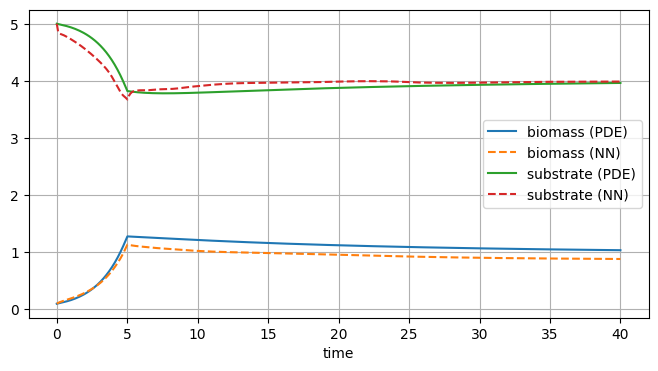

In [137]:
# torch.save(model.state_dict(), 'classicNN_integrodiff_normalized_(102x128x128x128x128x101)2000epoch_3e-4loss.pth')

#setting up a validation set: 
def D_func_step_val(t,i=None):
    return np.where(t < 5, 0.0, 0.5)

U_val=D_func_step_val(t=t_eval)

n0_val= shifted_gaussian(m,0.4,0.25)*2        #2 gramms of biomass at the start
S0=5
y0 = np.concatenate([n0, [S0]])

PDE= partial(
            population_system,
            m=m,
            q=q,
            Bqq=Bqq,
            delta_m=delta_m,
            se=se,
            minimal_division_mass=minimal_division_mass,
            D_func=D_func_step_val,
            i=None
        )

sol_val= solve_ivp(PDE, t_span, y0, t_eval=t_eval, method='RK45')


"""now for the simulation with the NN-->first i need to normalize the initial datapoint-->NN-->denormalize """
def rollout(model, n0, s0, u_seq, steps, X_mean, X_std, Y_mean, Y_std, device="cpu"):
    """
    model: trained NN mapping [n(t), s(t), u(t)] -> [n(t+1), s(t+1)]
    n0:    (M,) initial distribution
    s0:    scalar initial substrate
    u_seq: (steps,) sequence of inputs u(t), u(t+1), ...
    steps: number of forward steps to simulate
    returns:
        N: (M, steps+1) with columns n(0)..n(steps)
        S: (steps+1,) with s(0)..s(steps)
    """
    model.eval()
  

    M = n0.shape[0]
    N = np.zeros((M, steps+1), dtype=np.float32)
    S = np.zeros((steps+1,), dtype=np.float32)
    N[:, 0] = n0
    S[0] = s0

    for t in range(steps):
        x_raw = np.concatenate([N[:, t], [S[t], u_seq[t]]])  # shape (M+2,)
        x_norm = (x_raw - X_mean) / X_std

        x_tensor = torch.tensor(x_norm, dtype=torch.float32).unsqueeze(0)  # (1, M+2)
        y_norm = model(x_tensor)[0].detach().numpy()  # (M+1,)

        y_raw = y_norm * Y_std + Y_mean           # de-normalize
        N[:, t+1] = y_raw[:M]
        S[t+1] = y_raw[M]

    return N, S

N_pred, S_pred = rollout(model, n0, s0=S0, u_seq=U_val, steps=len(U_val), X_mean=X_mean, X_std=X_std, Y_mean=Y_mean, Y_std=Y_std)

j=timesteps
# Create a meshgrid for mass (m) and time (t)
T, M_  = np.meshgrid(sol_val.t[:j], m)  #200x100

# Extract corresponding n(m, t) values for the first j time points
N = sol_val.y[:-1, :]  # m,t

time_idxs = np.arange(0, N.shape[1], 2)

cmin, cmax = N.min(), N.max()
print(N.shape)
traces = []
for i, k in enumerate(time_idxs):
    traces.append(
        go.Scatter3d(
            x=M_[:, k],
            y=T[:, k],
            z=N[:, k],
            mode='lines',
            showlegend=False,           # still no legend for each line
            line=dict(
                color=N[:, k],          # color each point by its density
                colorscale='Viridis',
                cmin=cmin,
                cmax=cmax,
                width=4,
                showscale=(i == 0),       # only the first trace shows the colorbar, so i dont have 200 colorbars
                colorbar=dict(title='n(m, t)') if i == 0 else None
            )
        )
    )

fig = go.Figure(traces)
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='Mass (m)',
            autorange='reversed'    # flip so axis 0 and time axis 0 sort of fit better visually 
        ),
        yaxis=dict(title='Time (t)'),
        zaxis=dict(title='n(m, t)')
    ),
    width=700,
    height=700,
)
fig.show()

t_nn = sol_val.t[:min(j, N_pred.shape[1])]

# Meshgrid for NN (same m, time as PDE slice)
T_nn, M_nn = np.meshgrid(t_nn, m)  # shape: (M, time)

# Slice PDE data for fair comparison
N_pde = sol_val.y[:-1, :j]                   # (M, j)
S_pde = sol_val.y[-1, :j]                    # (j,)
N_nn  = N_pred[:, :len(t_nn)]                # (M, j')  j' == len(t_nn)
S_nn  = S_pred[:len(t_nn)]                   # (j',)

# Use a shared color scale range across PDE and NN for visual comparability
cmin = min(N_pde.min(), N_nn.min())
cmax = max(N_pde.max(), N_nn.max())

# To reduce over-plotting, subsample time curves (like your code)
time_idxs = np.arange(0, N_nn.shape[1], 2)

# --- 3D spaghetti plot for the NN prediction ---
traces_nn = []
for i, k in enumerate(time_idxs):
    traces_nn.append(
        go.Scatter3d(
            x=M_nn[:, k],
            y=T_nn[:, k],
            z=N_nn[:, k],
            mode='lines',
            showlegend=False,
            line=dict(
                color=N_nn[:, k],
                colorscale='Viridis',
                cmin=cmin, cmax=cmax,
                width=4,
                showscale=(i == 0),
                colorbar=dict(title='n(m, t)') if i == 0 else None
            )
        )
    )

fig_nn = go.Figure(traces_nn)
fig_nn.update_layout(
    title="NN prediction: n(m,t)",
    scene=dict(
        xaxis=dict(title='Mass (m)', autorange='reversed'),
        yaxis=dict(title='Time (t)'),
        zaxis=dict(title='n(m, t)')
    ),
    width=700, height=700,
)
fig_nn.show()

# --- Biomass & substrate over time (NN vs PDE) ---
# Biomass = sum(n_i(t) * m_i * delta_m)
biomass_pde = (N_pde * m[:, None]).sum(axis=0) * delta_m
biomass_nn  = (N_nn  * m[:, None]).sum(axis=0) * delta_m

plt.figure(figsize=(8,4))
plt.plot(sol_val.t[:len(biomass_pde)], biomass_pde, label='biomass (PDE)')
plt.plot(t_nn, biomass_nn, '--', label='biomass (NN)')
plt.plot(sol_val.t[:len(S_pde)], S_pde, label='substrate (PDE)')
plt.plot(t_nn, S_nn, '--', label='substrate (NN)')
plt.xlabel('time'); plt.grid(True); plt.legend(loc='best'); 
plt.show()

# Error estimation
Note that we only used our Model for the first half of the dataset that we calculated using the PDE so i only care about the mistake in the "predicted" part of the Neural Network, not the part that i specifically used the training data on.

(100, 400)
(100, 400)
100


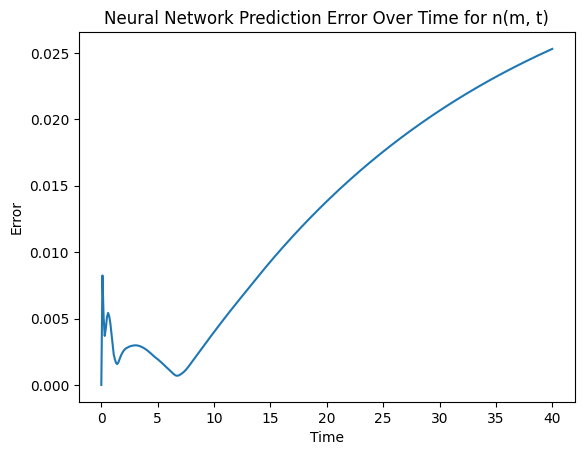

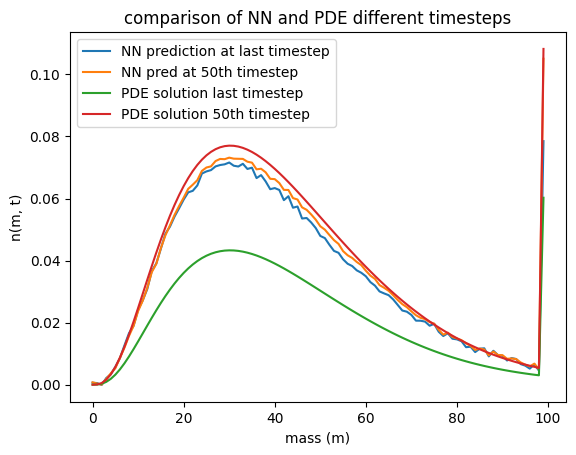

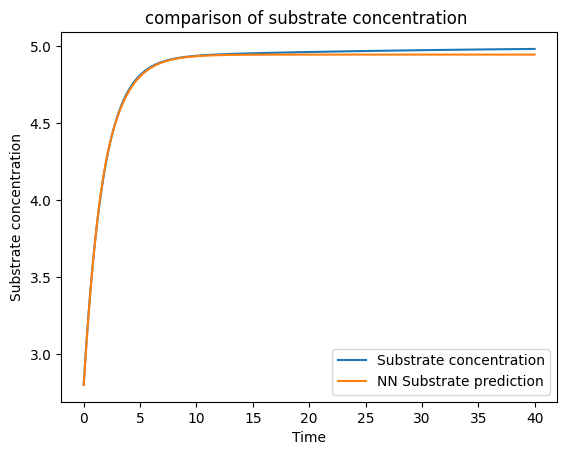

In [116]:
error=[]
# Calculate the error between the neural network predictions and the original solution (only for the Mass distribution!! not the substrate)
print(N_nn.shape)
print(sol.y[:-1].shape)
print(M)
for i in range(timesteps_nn):

    er=0
    
    for j in range (M):
        er+= np.linalg.norm(N_nn[j, i] - sol.y[:-1, i][j])/(M)
    error.append(er)


# Plot error over time as a separate plot
plt.figure()
plt.plot(t_eval[:timesteps], error)
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Neural Network Prediction Error Over Time for n(m, t)')
plt.show()

#
plt.figure()
plt.title('comparison of NN and PDE different timesteps')
plt.plot(N_nn.T[199])
plt.plot(N_nn.T[50])
plt.plot(sol.y[:-1, 199])
plt.plot(sol.y[:-1, 50])
plt.xlabel('mass (m)')
plt.ylabel('n(m, t)') 
plt.legend(['NN prediction at last timestep','NN pred at 50th timestep', 'PDE solution last timestep', 'PDE solution 50th timestep'])
plt.show()

plt.figure()
plt.title('comparison of substrate concentration ')
plt.plot(t_eval[:timesteps],sol.y[-1])
plt.plot(t_eval[:timesteps],np.array(solution)[:,-1])
plt.legend(['Substrate concentration','NN Substrate prediction'])
plt.xlabel('Time')
plt.ylabel('Substrate concentration')
plt.show()

# Conclusion
For this first attempt it appears that after we exceed the point of the training data, the model error grows rapidly. Obviously this is expected. However, it is noticable that after  the 50th timestep (approx at 2.5 seconds- the last timestep used for training), there is almost no change in the values estimated by the Neural Network. This can easily be observed in the Graph for the NN Substrate prediction

Why does this happen?

At first i was kind of expecting the NN to keep fitting the Data or at least fit the Data better, but since i only used 1 Dataset and only trained the model with  the first few seconds of that data, there was no training done using lower Substrate concentrations (as they would occur after timestep 50), so  the calculation of the DGL at lower Substrate concentrations simply would be outside the scope of the NN. To achieve better estimation i would need more training data that covers the entire range of possible substrate concentrations as well as a few more validation data sets.
The same obviously holds true for the $n(m,t)$ estimation.

Tldr:

- Not enough training Data
- Values are outside the scope of the NN




# Next step:

Increase the accuracy by using a ***Physics-informed Neural Network*** (PINN). In a PINN, the knowledge of physics of specific system behaviour is used to extend the Neural Network. For this, the loss function needs to be tailored to the differential equation one assumes could describe the system. I know it is not a "source", but Wikipedia also says that this type of NN is particularly helpful for partial differential equations. The PINN should then be better suited to describe the model, even slightly outside of the training interval. In general, the loss function for a PINN is constructed as follows:

Assume that the dataset originates from a system that can be described by a general PDE: 
$$
\frac{\partial n}{\partial t} = \frac{\partial n}{\partial m} + f(c)
$$
Solving for zero gives us:
$$
\frac{\partial n}{\partial t} - \frac{\partial n}{\partial m} - f(c) = 0
$$
and this is the part that will now be added to the loss function, so that
the loss function for the PINN becomes:
$$
\mathcal{L} = \mathcal{L}_{\text{data}} + \lambda \, \mathcal{L}_{\text{PDE}}
$$
where $\mathcal{L}_{\text{data}}$ is the standard data loss (e.g., MSE between predicted and true values), $\mathcal{L}_{\text{PDE}}$ is the mean squared residual of the PDE:
$$
\mathcal{L}_{\text{PDE}} = \frac{1}{N} \sum_{i=1}^N \left| \left(\frac{\partial n}{\partial t}\right)_{\text{NN}} - \left(\frac{\partial n}{\partial m}\right)_{\text{NN}} - f(c) \right|^2
$$
and $\lambda$ is a weighting parameter that balances the two terms. This encourages the neural network to fit the data while also satisfying the underlying physics described by the PDE.


Here, $N$ represents the number of *collocation points*, i.e., the discrete points in the $(m, t)$ domain where the PDE residual is evaluated. 
Importantly, these collocation points do **not** have to coincide with the training data points; they can be chosen independently and even be sampled more densely or sparsely within the domain to enforce the physical constraints throughout the solution space. This flexibility allows the PINN to generalize the physical laws beyond just the observed data. Basically ensuring that the NN obeys the PDE across the whole domain